# Testing of queue imbalance for stock 7858

Order of this notebook is as follows:
1. [Data](#Data)
2. [Data visualization](#Data-visualization)
3. [Tests](#Tests)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [[1]](#Resources).

In [1]:
%matplotlib inline
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt

import matplotlib.dates as md
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns
import warnings


import lob

warnings.filterwarnings('ignore')

## Data

Market is open between 8-16 on every weekday. We decided to use data from only 9-15 for each day.

### Test and train data

For training data we used data from 2013-09-01 - 2013-11-16:

* 0901
* 0916
* 1001
* 1016
* 1101

We took 75% of this data (randomly), the rest is the test data.

In [2]:
df, df_test = lob.load_prepared_data('7858', data_dir='../data/prepared/', length=None)
df.head()

Len of data for  7858 is 13791
Training set length for 7858: 11033
Testing set length for 7858: 2758


,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2758,2013-09-18 10:43:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4490.0, 1025.0), (4491.0, 201.0), (4492.0, 5...",4486.0,4490.0,4488.0,1025.0,640.0,0.0,-0.231231
2759,2013-09-18 10:44:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4489.0, 807.0), (4490.0, 272.0), (4491.0, 50...",4486.0,4489.0,4487.5,807.0,440.0,0.0,-0.294306
2760,2013-09-18 10:45:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4488.0, 528.0), (4489.0, 726.0), (4490.0, 52...",4485.0,4488.0,4486.5,528.0,600.0,0.0,0.063830
2761,2013-09-18 10:46:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4488.0, 157.0), (4489.0, 621.0), (4490.0, 58...",4484.0,4488.0,4486.0,157.0,667.0,1.0,0.618932
2762,2013-09-18 10:47:00,"[(2800.0, 500.0), (4100.0, 300.0), (4120.0, 50...","[(4489.0, 630.0), (4490.0, 397.0), (4491.0, 96...",4486.0,4489.0,4487.5,630.0,73.0,1.0,-0.792319


## Data visualization

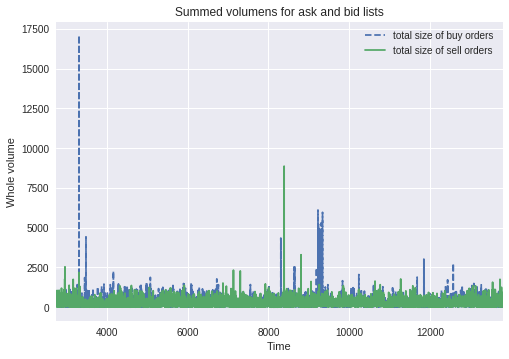

In [3]:
df['sum_buy_bid'].plot(label='total size of buy orders', style='--')
df['sum_sell_ask'].plot(label='total size of sell orders', style='-')
plt.title('Summed volumens for ask and bid lists')
plt.xlabel('Time')
plt.ylabel('Whole volume')
plt.legend()

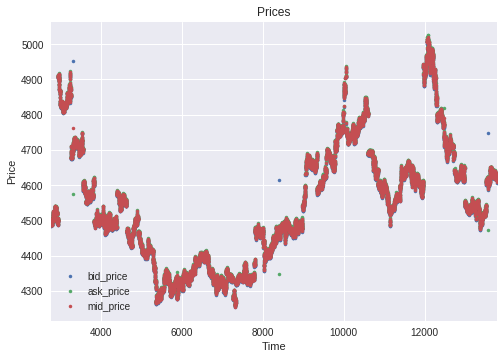

In [4]:
df[['bid_price', 'ask_price', 'mid_price']].plot(style='.')
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

[]

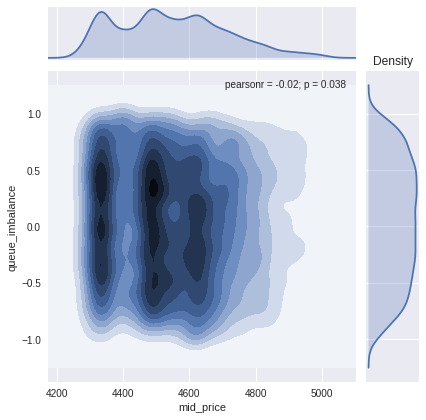

In [5]:
sns.jointplot(x="mid_price", y="queue_imbalance", 
              data=df.loc[:, ['mid_price', 'queue_imbalance']], kind="kde")
plt.title('Density')
plt.plot()

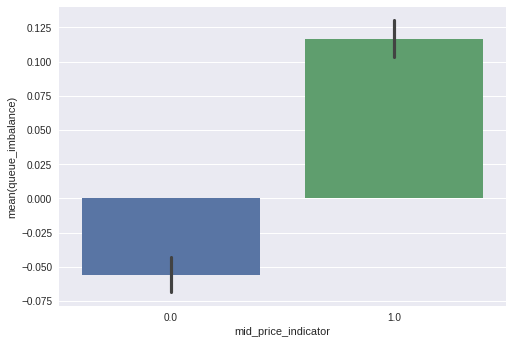

In [6]:
sns.barplot(x = 'mid_price_indicator', y = 'queue_imbalance', data=df)

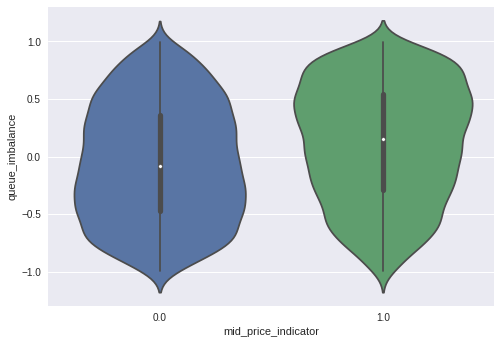

In [7]:
sns.violinplot(x='mid_price_indicator', 
               y='queue_imbalance', data=df, split=False)

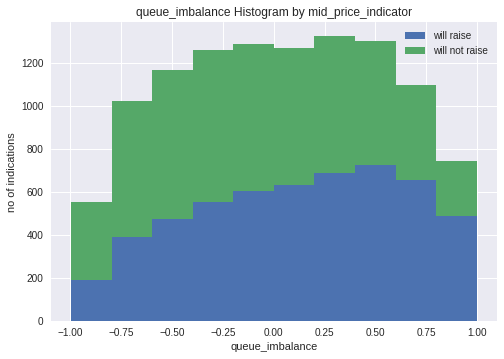

In [8]:
plt.hist(x = [df[df['mid_price_indicator']==1]['queue_imbalance'], 
              df[df['mid_price_indicator']==0]['queue_imbalance']],
         stacked=True, label = ['will raise', 'will not raise'])
plt.title('queue_imbalance Histogram by mid_price_indicator')
plt.xlabel('queue_imbalance')
plt.ylabel('no of indications')
plt.legend()

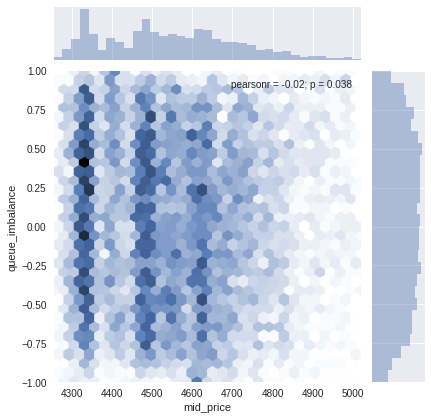

In [9]:
sns.jointplot("mid_price", "queue_imbalance", data=df, kind='hex');

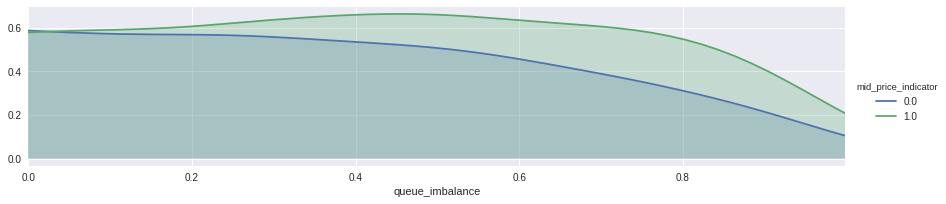

In [10]:
# plot distribution of queue imbalacne for which mid_price_ind is 0 or 1
a = sns.FacetGrid(df, hue = 'mid_price_indicator', aspect=4 )
a.map(sns.kdeplot, 'queue_imbalance', shade= True )
a.set(xlim=(0 , df['queue_imbalance'].max()))
a.add_legend()

In [11]:
df[['queue_imbalance', 'mid_price_indicator']].corr()

,queue_imbalance,mid_price_indicator
queue_imbalance,1.000000,0.166476
mid_price_indicator,0.166476,1.000000


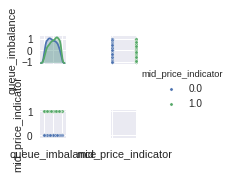

In [12]:
pp = sns.pairplot(df[['queue_imbalance', 'mid_price_indicator']], 
                  hue = 'mid_price_indicator', 
                  palette = 'deep', size=1.2, diag_kind = 'kde', 
                  diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

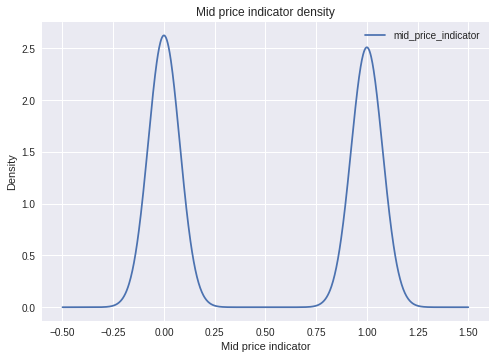

In [13]:
df['mid_price_indicator'].plot('kde')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

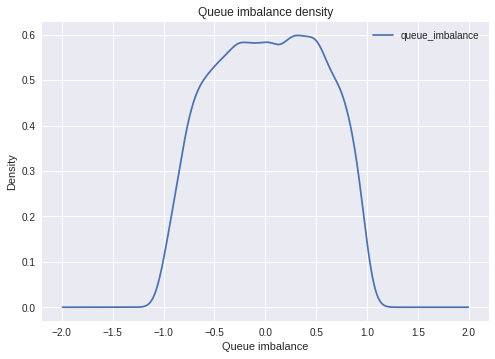

In [14]:
df['queue_imbalance'].plot('kde')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

## Tests

We use logistic regression to predict `mid_price_indicator`.

### Mean square error 

We calculate residual $r_i$:

$$ r_i = \hat{y_i} - y_i $$

where 

$$ \hat{y}(I) = \frac{1}{1 + e −(x_0 + Ix_1 )}$$

Calculating mean square residual for all observations in the testing set is also useful to assess the predictive power.

The predective power of null-model is 25%.

In [15]:
reg = lob.logistic_regression(df, 0, len(df))

probabilities = reg.predict_proba(df_test['queue_imbalance'].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
err = ((df_test['mid_price_indicator'] - probabilities) ** 2).mean()

predictions = reg.predict(df_test['queue_imbalance'].values.reshape(-1, 1))

print('Mean square error is', err)

Mean square error is 0.23971951196233848


#### Logistic regression fit curve

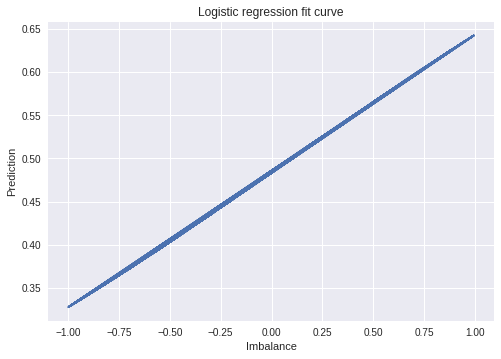

In [16]:
plt.plot(df_test['queue_imbalance'].values, 
         lob.sigmoid(reg.coef_[0] * df_test['queue_imbalance'].values + reg.intercept_))
plt.title('Logistic regression fit curve')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')

#### ROC curve

For assessing the predectivity power we can calculate ROC score.

0.583793269725


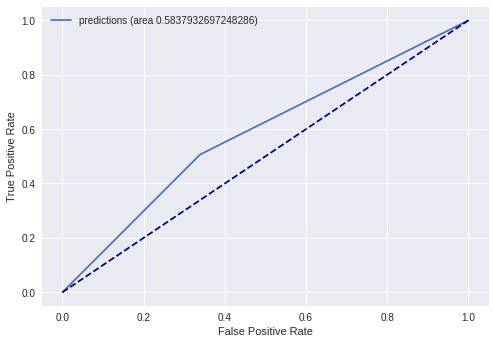

In [17]:
a, b, c = roc_curve(df_test['mid_price_indicator'], predictions)
logit_roc_auc = roc_auc_score(df_test['mid_price_indicator'], predictions)
print(logit_roc_auc)
plt.plot(a, b, label='predictions (area {})'.format(logit_roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

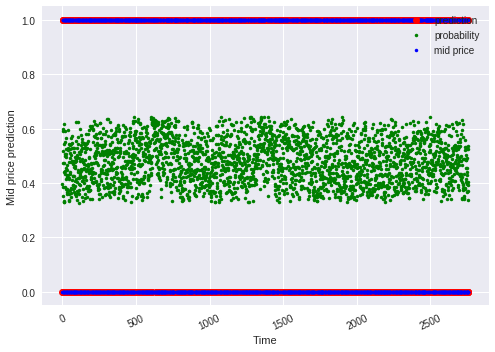

In [18]:
st = 0
end = len(df)
plt.plot(df_test.index[st:end], predictions[st:end], 'ro', label='prediction')
plt.plot(df_test.index[st:end], probabilities[st:end], 'g.', label='probability')
plt.plot(df_test.index[st:end], df_test['mid_price_indicator'].values[st:end], 'b.', label='mid price')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Mid price prediction')

## Conclusions

Looking at mid_price_indicator density plot it seems that bid and ask queues are balanced. The same conclusion we can get from queue imbalance density plot - most often the queues are balanced.


* predicted probability vs known indicator: 0.248, so it's slightly better than null-model (0.25). 
* area under ROC curve is 0.534, for null-model it's 0.50.

We didn't remove outliers.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a> 